In [1]:
import cv2
import numpy as np
import pickle

def collect_video_framecount(action,subject,trial_num):
    
    action_dict = {'KT':'Knot_Tying','S':'Suturing','NP': 'Needle_Passing'}
    
    act = action_dict[action]

    filename1 = act+'/video/'+act+'_'+subject+'00'+str(trial_num)+'_capture1.avi'
    filename2 = act+'/video/'+act+'_'+subject+'00'+str(trial_num)+'_capture2.avi'
    
    print('reading '+filename1)
    
    vidcap1 = cv2.VideoCapture(filename1)
    vidcap2 = cv2.VideoCapture(filename2)
    
    count = 0
    success = True
    
    while success:
      success,image = vidcap1.read()
    
      '''
      success,image = vidcap2.read()
      '''  
      count += 1

    print('total frame count : %d' % count)
    
    return count-1

def collect_video_sample(action,subject,trial_num,num_frames):
    
    action_dict = {'KT':'Knot_Tying','S':'Suturing','NP': 'Needle_Passing'}
    
    act = action_dict[action]

    filename1 = act+'/video/'+act+'_'+subject+'00'+str(trial_num)+'_capture1.avi'
    filename2 = act+'/video/'+act+'_'+subject+'00'+str(trial_num)+'_capture2.avi'
    
    print('reading '+filename1)
    
    vidcap1 = cv2.VideoCapture(filename1)
    vidcap2 = cv2.VideoCapture(filename2)
    
    # collect kinematic data
    filepath = act + '/kinematics/AllGestures/'
    filename = filepath + act + '_' +subject + '00' + str(trial_num) + '.txt'
    data = np.loadtxt(filename)
    num_labels = data.shape[0]
    print('total labels loaded: %d' % num_labels)
    
    if (num_labels>num_frames):
          pass
    else:
          num_frames = num_labels
          
    count = 0
    success = True
    
    while success and count<num_frames:
      success,image = vidcap1.read()
      write_name = 'data/' + subject+'_'+str(trial_num)+'_1'+'_%d_'+ action + '.png'
      cv2.imwrite(write_name % count, image)     # save frame as png file
    
      '''
      success,image = vidcap2.read()
      write_name = 'data/' + subject+'_'+str(trial_num)+'_2'+'_%d_'+ action + '.png'
      cv2.imwrite(write_name % count, image)     # save frame as png file
      '''
      count += 1
      if count%100 == 0:
          print('capturing frame %d' % count)  
    
    print('total frame count : %d' % count)
    
    # only take cols 38-49 (slave left) and 57-68 (slave right)
    
    dataL = data[:count,38:50]
    dataR = data[:count,57:69]
    
    out = np.hstack((dataL,dataR))
    
    print('total labels saved: %d' % out.shape[0])
    
    return out

 

In [ ]:
subject_list = {}
subject_list['KT'] = [['B','C','D','E','F','G','H','I'],[[0,1,2,3],[0,1,2,3,4],[0,1,2,3,4],[0,1,2,3,4],[0,1,2,3,4],[0,1,2,3,4],[2,3,4],[0,1,2,4]]]
#subject_list['KT'] = [['B'],[4]]

y = np.empty((0,24))

task = 'KT'
subj = subject_list[task][0]
trial = subject_list[task][1]
for i in range(len(subj)):
    for j in trial[i]:
        num_frames = collect_video_framecount(task,subj[i],j+1)
        out = collect_video_sample(task,subj[i],j+1,num_frames)
        y = np.vstack((y,out))

import pickle

print(y.shape)
picklefile = open('kinematics', 'wb') 
pickle.dump(y,picklefile)
picklefile.close()

In [ ]:
# GOT THIS ONLINE, NEED TO FIGURE OUT HOW TO CITE IT https://www.lfd.uci.edu/~gohlke/code/transformations.py.html

def quaternion_from_matrix(matrix, isprecise=False):

    M = np.array(matrix, dtype=np.float64, copy=False)[:4, :4]
    if isprecise:
        q = np.empty((4, ))
        t = np.trace(M)
        if t > M[3, 3]:
            q[0] = t
            q[3] = M[1, 0] - M[0, 1]
            q[2] = M[0, 2] - M[2, 0]
            q[1] = M[2, 1] - M[1, 2]
        else:
            i, j, k = 0, 1, 2
            if M[1, 1] > M[0, 0]:
                i, j, k = 1, 2, 0
            if M[2, 2] > M[i, i]:
                i, j, k = 2, 0, 1
            t = M[i, i] - (M[j, j] + M[k, k]) + M[3, 3]
            q[i] = t
            q[j] = M[i, j] + M[j, i]
            q[k] = M[k, i] + M[i, k]
            q[3] = M[k, j] - M[j, k]
            q = q[[3, 0, 1, 2]]
        q *= 0.5 / math.sqrt(t * M[3, 3])
    else:
        m00 = M[0, 0]
        m01 = M[0, 1]
        m02 = M[0, 2]
        m10 = M[1, 0]
        m11 = M[1, 1]
        m12 = M[1, 2]
        m20 = M[2, 0]
        m21 = M[2, 1]
        m22 = M[2, 2]
        # symmetric matrix K
        K = np.array([[m00-m11-m22, 0.0,         0.0,         0.0],
                         [m01+m10,     m11-m00-m22, 0.0,         0.0],
                         [m02+m20,     m12+m21,     m22-m00-m11, 0.0],
                         [m21-m12,     m02-m20,     m10-m01,     m00+m11+m22]])
        K /= 3.0
        # quaternion is eigenvector of K that corresponds to largest eigenvalue
        w, V = np.linalg.eigh(K)
        q = V[[3, 0, 1, 2], np.argmax(w)]
    if q[0] < 0.0:
        np.negative(q, q)
    return q

In [ ]:
subject_list = {}
subject_list['KT'] = [['B','C','D','E','F','G','H','I'],[[0,1,2,3],[0,1,2,3,4],[0,1,2,3,4],[0,1,2,3,4],[0,1,2,3,4],[0,1,2,3,4],[2,3,4],[0,1,2,4]]]

task = 'KT'
act = 'Knot_Tying'
subj = subject_list[task][0]
trial = subject_list[task][1]

y = np.empty((0,14)) # 6 for position, 24 for direction cosines, 14 for quaternion

index_dict = {}

for i in range(len(subj)):
    for j in trial[i]:
        # collect kinematic data
        count = collect_video_framecount(task,subj[i],j+1)
        filepath = act + '/kinematics/AllGestures/'
        filename = filepath + act + '_' + subj[i] + '00' + str(j+1) + '.txt'
        data = np.loadtxt(filename)
        
        r_test = data[0, 3:12]
        
        num_labels = data.shape[0]
        print('total labels loaded: %d' % num_labels)
        dataL_pos = data[:count,39:42]
        dataR_pos = data[:count,57:60]
        
        dataL_rot = data[:count, 41:50]
        dataR_rot = data[:count, 60:69]
        
        # now we change the representation of the rotation to quaternion
        N = dataL_rot.shape[0]
        dataL_quat = np.zeros((N, 4))
        dataR_quat = np.zeros((N, 4))
        for k in range(N):
            L_rot = np.asarray(dataL_rot[k, :]).reshape((3,3))
            R_rot = np.asarray(dataR_rot[k, :]).reshape((3,3))

            dataL_quat[k,:] = quaternion_from_matrix(L_rot)
            dataR_quat[k,:] = quaternion_from_matrix(R_rot)
        
        dataL = np.hstack((dataL_pos, dataL_quat))
        dataR = np.hstack((dataR_pos, dataR_quat))
        out = np.hstack((dataL,dataR))
        print(out.shape)
        
        index_dict[subj[i] + '00' + str(j+1)] = list(range(y.shape[0], y.shape[0] + out.shape[0]))
        
        y = np.vstack((y,out))
import pickle

print(y.shape)
picklefile = open('kinematics', 'wb') 
pickle.dump(y,picklefile)
picklefile.close()

In [17]:
# functions to downsize the images and compile them into a dataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import Dataset
import os

import torchvision.datasets as dset
import torchvision.transforms as T
import glob
from PIL import Image
import cv2
import numpy as np
import pickle
from natsort import humansorted
import pdb

class JIGSAWDataset(Dataset):

    def __init__(self, y, sortedFilelist , transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            sortedFilelist (string): sorted list of filenames.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels = y
        self.sortedlist = sortedFilelist
        self.transform = transform

    def __len__(self):
        return self.y.shape[0]
        
    def __getitem__(self, idx): 
        img_name = self.sortedlist[idx]
        #print('opening image ' +  img_name)
        image = Image.open(img_name,'r')
        label = self.labels[idx,:]
        if self.transform:
            image = self.transform(image)
        sample =  (image,label)

        return sample

def load_dataset():
    
    data_path = 'data'
    picklefile = open("kinematics", "rb" )
    
    num_files = len(next(os.walk('data'))[2]) #dir is your directory path as string
    print(num_files)
    
    trans_height = 10 
    trans_width = 15
    
    trans = T.Compose([
                T.Resize((trans_height,trans_width), interpolation=2),
                T.ToTensor()])
    transy = T.Compose([T.ToTensor()])

    y = pickle.load(picklefile)
    print(y.shape)
    picklefile.close()
    
    dataset = JIGSAWDataset(y,data_path,transform = trans)
    
    num_train_trials = 3
    num_val_trials = 1
        
    range_total = np.asarray(random.sample(list(index_dict.values()), k=(num_train_trials + num_val_trials)))
    range_train = list(range_total[:num_train_trials].flatten())[0]
    range_val = list(range_total[num_train_trials:num_train_trials+num_val_trials].flatten())[0]
    
    train_loader = DataLoader(
        dataset,
        batch_size=25,
        num_workers=0,
        shuffle=False,
#         sampler=sampler.SubsetRandomSampler(range(num_files-2000))
        sampler=sampler.SubsetRandomSampler(range_train)
    )
    
    val_loader = DataLoader(
        dataset,
        batch_size=25,
        num_workers=0,
        shuffle=False,
#         sampler=sampler.SubsetRandomSampler(range(num_files-2000,num_files))
        sampler=sampler.SubsetRandomSampler(range_val)
    )
    
    return train_loader,val_loader
    
loader_train,loader_val = load_dataset()


USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

61614
(61614, 6)
using device: cuda


In [12]:
def check_accuracy_part34(loader, model):

    print('Checking accuracy on validation set')

    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float)
            scores = model(x)
            loss_fn = torch.nn.MSELoss(reduction='mean')
            loss = loss_fn(scores,y)

        print('MSE loss is: %d ' % loss)

def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float)
            
            scores = model(x)
            loss_fn = torch.nn.MSELoss(reduction='sum')
            loss = loss_fn(scores,y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
            if t % 5 == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_train, model)
                print()
            

In [ ]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

model = None
optimizer = None

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

channel_1 = 16
channel_2 = 32
channel_3 = 64
hidden_size = 1000
learning_rate = 1e-3
reg = 1e-5

# computing the output from the conv nets
pad1 = 2 
filt1 = 5
im_H = 60
im_W = 80
stride1 = 1
wout1 = (im_W + 2*pad1 - filt1 )/stride1 + 1
hout1 = (im_H + 2*pad1 - filt1 )/stride1 + 1
print('%d %d' %(wout1,hout1))
pad2 = 1
filt2 = 5
stride2 =2
wout2 = (wout1 + 2 *pad2 - filt2 )/stride2 + 1
hout2 = (hout1 + 2 *pad2 - filt2 )/stride2 + 1
print('%d %d' %(wout2,hout2))
pad3 = 1
filt3 = 2
stride3 = 2
wout3 = (wout2 + 2 *pad3 - filt3 )/stride3 + 1
hout3 = (hout2 + 2 *pad3 - filt3 )/stride3 + 1
print('%d %d' %(wout3,hout3))
linear_input_dim = int(channel_3*hout3*wout3)
print('linear input dim required: ' ,linear_input_dim)

model = nn.Sequential(
    nn.Conv2d(3,channel_1,filt1,padding=pad1,stride = stride1),
    nn.BatchNorm2d(channel_1),
    nn.ReLU(),
    nn.Conv2d(channel_1,channel_2,filt2,padding=pad2, stride = stride2),
    nn.BatchNorm2d(channel_2),
    nn.ReLU(),
    nn.Conv2d(channel_2,channel_3,filt3,padding=pad3,stride = stride3),
    nn.BatchNorm2d(channel_3),
    nn.ReLU(),
    Flatten(),
    nn.Linear(4096,hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,6),
)

# you can use Nesterov momentum in optim.SGD
#optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9, nesterov=True)

optimizer = optim.Adam(model.parameters(),lr = learning_rate, weight_decay = reg)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

# You should get at least 70% accuracy
train_part34(model, optimizer, epochs=1)

80 60
39 29
20 15
linear input dim required:  20916
Iteration 0, loss = 8.9767
Checking accuracy on validation set


61614
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=320x240 at 0x7F1D28DB76A0>


'\ny = pickle.load(picklefile)\npicklefile.close()\n\ndataset = JIGSAWDataset(y,data_path,transform = trans)\n'

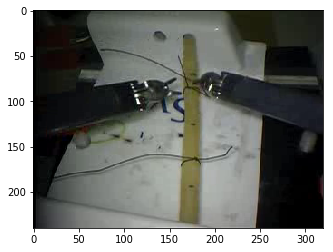

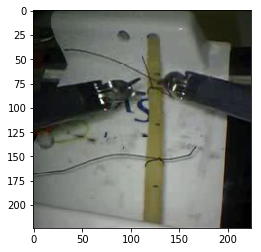

In [9]:
import matplotlib.pyplot as plt

data_path = 'data'
picklefile = open("kinematics", "rb" )

num_files = len(next(os.walk('data'))[2]) #dir is your directory path as string
print(num_files)

trans = T.Compose([
            T.Resize((60,80), interpolation=2),
            T.ToTensor()])
transy = T.Compose([T.ToTensor()])
transr = T.Compose([T.CenterCrop(240),T.Resize((224,224), interpolation=2)])

image = Image.open('data/G_5_1_918_KT.png','r')
print(image)
plt.imshow(image)
plt.figure()
image = transr(image)
plt.imshow(image)

'''
y = pickle.load(picklefile)
picklefile.close()

dataset = JIGSAWDataset(y,data_path,transform = trans)
'''